In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os 
if(not os.path.isdir('/content/dataset/wider')):
  os.makedirs('/content/dataset/wider')

In [0]:
!unzip -uq '/content/gdrive/My Drive/WIDER_test.zip' -d /content/dataset/wider
!unzip -uq '/content/gdrive/My Drive/WIDER_train.zip' -d /content/dataset/wider
!unzip -uq '/content/gdrive/My Drive/WIDER_val.zip' -d /content/dataset/wider
!unzip -uq '/content/gdrive/My Drive/wider_face_split.zip' -d /content/dataset/wider

In [0]:
!git clone https://github.com/sukhoi/py-wider2pascal.git

Cloning into 'py-wider2pascal'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
tf.__version__

'1.15.2'

In [0]:
!python '/content/gdrive/My Drive/wider2pascal.py'

Generating Annotations: TRAIN
Generating Annotations: TEST
Copying Images : TRAIN
Copying Images : TEST
Generating ImageSets: TRAIN
Generating ImageSets: TEST
PASCAL VOC format WIDER dataset at /content/dataset/wider_pascal


In [0]:
!cp -r '/content/dataset/wider_pascal'  '/content/gdrive/My Drive'

cp: cannot stat '/content/dataset/wider_pascal': No such file or directory


In [0]:
#!git clone https://github.com/pixiedust18/Mask_RCNN.git
%cd Mask_RCNN
!python setup.py install

/content/Mask_RCNN
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.

In [0]:
import os 
if(not os.path.isdir('/content/dataset/wider')):
  os.makedirs('/content/dataset/wider')
!cp "/content/gdrive/My Drive/mask_rcnn_coco.h5" "/content/Mask_RCNN/"

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1766233421057758698, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2717346641617061519
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 278994592911635963
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8208340377498423910
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
!git clone https://github.com/tensorflow/tpu/

In [0]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [0]:
!pip install keras==2.1.5

     |████████████████████████████████| 337kB 2.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn.utils import compute_ap
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree

Using TensorFlow backend.


In [0]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1000
    
    # Learning rate
    LEARNING_RATE=0.001
    VALIDATION_STEPS = 500

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10
    TRAIN_BN = None # Defaulting to False since batch size is often small

    # Gradient norm clipping
    GRADIENT_CLIP_NORM = 5.0
    def __init__(self):
      """Set values of computed attributes."""
      # Effective batch size
      self.BATCH_SIZE = self.GPU_COUNT * self.IMAGES_PER_GPU
      # Input image size
      if self.IMAGE_RESIZE_MODE == "crop":
        self.IMAGE_SHAPE = np.array([self.IMAGE_MIN_DIM, self.IMAGE_MIN_DIM,
            self.IMAGE_CHANNEL_COUNT])
      else:
        self.IMAGE_SHAPE = np.array([self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM,
            self.IMAGE_CHANNEL_COUNT])

    # Image meta data length
    # See compose_image_meta() for details
      self.IMAGE_META_SIZE = 1 + 3 + 3 + 4 + 1 + self.NUM_CLASSES

        

In [0]:
'''class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = 'mrcnn_config'  # Override in sub-classes

    # NUMBER OF GPUs to use. For CPU training, use 1
    GPU_COUNT = 1

    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 1000

    VALIDATION_STEPS = 20
    
    BACKBONE = "resnet101"
    IMAGE_META_SIZE = 1 + 3 + 3 + 4 + 1 + 2

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]

    # Number of classification classes (including background)
    NUM_CLASSES = 1  # Override in sub-classes

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]

    # Anchor stride
    # If 1 then anchors are created for each cell in the backbone feature map.
    # If 2, then anchors are created for every other cell, and so on.
    RPN_ANCHOR_STRIDE = 1

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000

    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)

    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 1024
    # If True, pad images with zeros such that they're (max_dim by max_dim)
    IMAGE_PADDING = True  # currently, the False option is not supported

    # Image mean (RGB)
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])
    TRAIN_ROIS_PER_IMAGE = 10

    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Pooled ROIs
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 10

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 50

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.8

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

    LEARNING_RATE = 0.0006
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    # Use RPN ROIs or externally generated ROIs for training
    # Keep this True for most situations. Set to False if you want to train
    # the head branches on ROI generated by code rather than the ROIs from
    # the RPN. For example, to debug the classifier head without having to
    # train the RPN.
    USE_RPN_ROIS = True

    # Train or freeze batch normalization layers
    #     None: Train BN layers. This is the normal mode
    #     False: Freeze BN layers. Good when using a small batch size
    #     True: (don't use). Set layer in training mode even when inferencing
    TRAIN_BN = True # Defaulting to False since batch size is often small

    # Gradient norm clipping
    GRADIENT_CLIP_NORM = 5.0
    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = 16

        # Input image size
        self.IMAGE_SHAPE = np.array(
            [self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM, 3])'''


        

In [0]:
config = myMaskRCNNConfig()

In [0]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
val_list = []
train_list = []

def train_func():
  train_file = open("/content/dataset/wider_pascal/WIDER/ImageSets/train.txt", "r")

  for line in train_file:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    train_list.append(line_list)

  train_file.close()

  print(train_list)

def val_func():
  val_file = open("/content/dataset/wider_pascal/WIDER/ImageSets/val.txt", "r")

  for line in val_file:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    val_list.append(line_list)

  val_file.close()

  print(val_list)


In [0]:
train_func()

[['0_Parade_marchingband_1_849'], ['0_Parade_Parade_0_904'], ['0_Parade_marchingband_1_799'], ['0_Parade_marchingband_1_117'], ['0_Parade_marchingband_1_778'], ['0_Parade_Parade_0_343'], ['0_Parade_marchingband_1_205'], ['0_Parade_Parade_0_106'], ['0_Parade_Parade_0_476'], ['0_Parade_marchingband_1_12'], ['0_Parade_marchingband_1_273'], ['0_Parade_marchingband_1_928'], ['0_Parade_Parade_0_337'], ['0_Parade_marchingband_1_579'], ['0_Parade_Parade_0_90'], ['0_Parade_marchingband_1_300'], ['0_Parade_Parade_0_782'], ['0_Parade_Parade_0_449'], ['0_Parade_Parade_0_325'], ['0_Parade_Parade_0_136'], ['0_Parade_Parade_0_1014'], ['0_Parade_marchingband_1_454'], ['0_Parade_marchingband_1_483'], ['0_Parade_Parade_0_87'], ['0_Parade_marchingband_1_193'], ['0_Parade_Parade_0_156'], ['0_Parade_marchingband_1_631'], ['0_Parade_Parade_0_469'], ['0_Parade_Parade_0_438'], ['0_Parade_marchingband_1_462'], ['0_Parade_marchingband_1_624'], ['0_Parade_Parade_0_138'], ['0_Parade_Parade_0_570'], ['0_Parade_Par

In [0]:
val_func()

[['0_Parade_marchingband_1_465'], ['0_Parade_Parade_0_628'], ['0_Parade_marchingband_1_765'], ['0_Parade_Parade_0_194'], ['0_Parade_marchingband_1_379'], ['0_Parade_Parade_0_814'], ['0_Parade_Parade_0_470'], ['0_Parade_marchingband_1_1045'], ['0_Parade_marchingband_1_556'], ['0_Parade_Parade_0_829'], ['0_Parade_marchingband_1_593'], ['0_Parade_Parade_0_29'], ['0_Parade_Parade_0_72'], ['0_Parade_Parade_0_205'], ['0_Parade_marchingband_1_881'], ['0_Parade_marchingband_1_490'], ['0_Parade_Parade_0_125'], ['0_Parade_Parade_0_120'], ['0_Parade_marchingband_1_476'], ['0_Parade_marchingband_1_620'], ['0_Parade_Parade_0_960'], ['0_Parade_marchingband_1_488'], ['0_Parade_Parade_0_901'], ['0_Parade_marchingband_1_822'], ['0_Parade_marchingband_1_353'], ['0_Parade_marchingband_1_74'], ['0_Parade_marchingband_1_234'], ['0_Parade_marchingband_1_359'], ['0_Parade_Parade_0_266'], ['0_Parade_Parade_0_275'], ['0_Parade_Parade_0_478'], ['0_Parade_Parade_0_913'], ['0_Parade_marchingband_1_172'], ['0_Para

In [0]:
len(train_list)

12880

In [0]:
class EvalImage():
  def __init__(self,dataset,model,cfg):
    self.dataset = dataset
    self.model   = model
    self.cfg     = cfg

 
 
  def evaluate_model(self , len = len(val_list)):
    APs = list()
    precisions_dict = {}
    recall_dict     = {}
    for index,image_id in enumerate(self.dataset.image_ids):
      if(index > len):
         break; 
      # load image, bounding boxes and masks for the image id
      image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(self.dataset, self.cfg,image_id, use_mini_mask=False)
      # convert pixel values (e.g. center)
      #scaled_image = modellib.mold_image(image, self.cfg)
      # convert image into one sample
      sample = np.expand_dims(image, 0)
     # print(len(image))
      # make prediction
      yhat = self.model.detect(sample, verbose=1)
      # extract results for first sample
      r = yhat[0]
      # calculate statistics, including AP
      AP, precisions, recalls, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
      precisions_dict[image_id] = np.mean(precisions)
      recall_dict[image_id] = np.mean(recalls)
      # store
      APs.append(AP)

    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP,precisions_dict,recall_dict

# New Section

In [0]:
class Wider(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "face")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/JPEGImages/'
        annotations_dir = dataset_dir + '/Annotations/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        if is_train:
          for filename in train_list:
            
            # extract image id
            image_id = filename[0] 
            
            # setting image file
            img_path = images_dir + filename[0]+'.jpg'
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

        else:
          for filename in val_list:
            
          # extract image id
            image_id = filename[0]         
            
          # setting image file
            img_path = images_dir + filename[0] +'.jpg'
            
          # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
          # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('face'))
        return masks, asarray(class_ids, dtype='int32')
# load an image reference
    """Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [0]:
train_set = Wider()
train_set.load_dataset('/content/dataset/wider_pascal/WIDER', is_train=True)

In [0]:
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 12880


In [0]:
p = listdir('/content/dataset/wider_pascal/WIDER/JPEGImages')

In [0]:
mask, class_id = train_set.load_mask(900)
print(mask, class_id)


[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]] [1 1 1 1 1 1 1 1 1]


12318


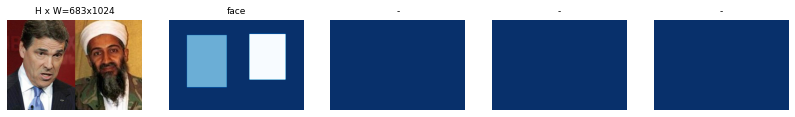

7741


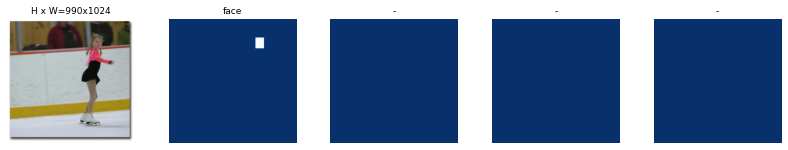

12410


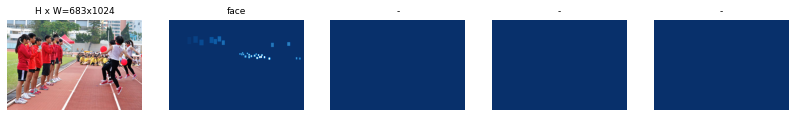

12509


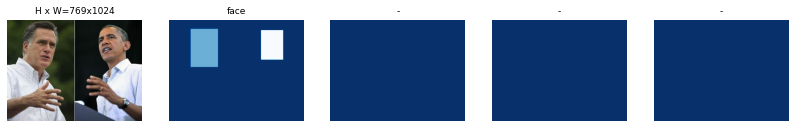

In [0]:
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    print(image_id)
    image =train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

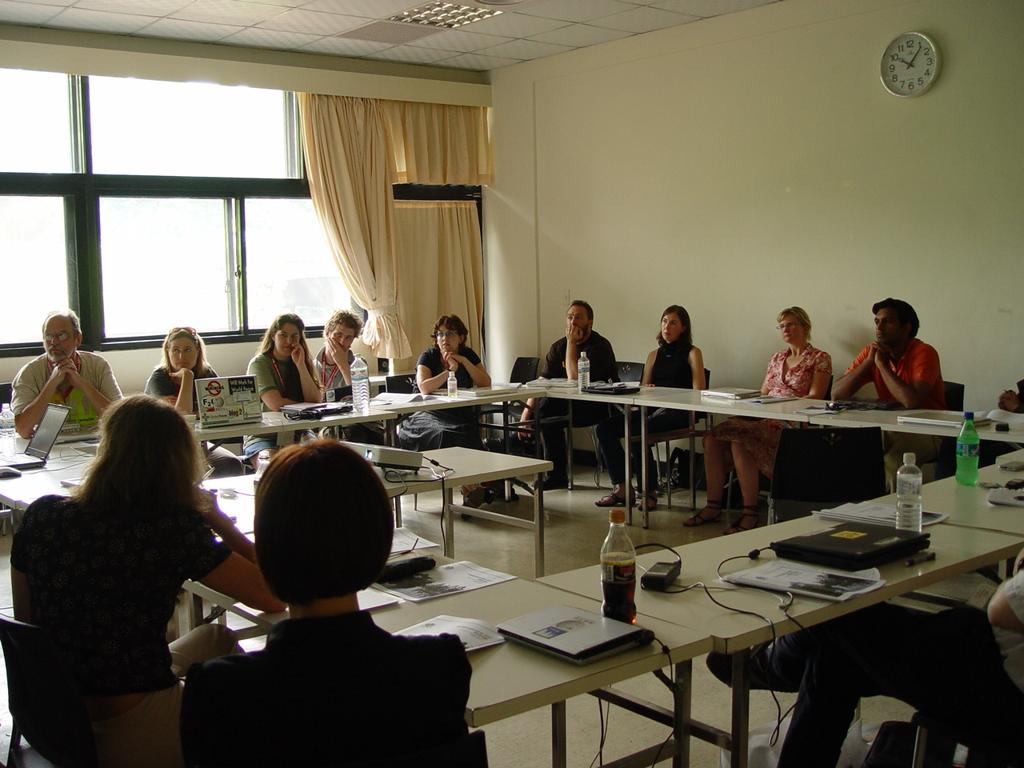

In [0]:
from google.colab.patches import cv2_imshow
imgName = train_list[900][0]
pathIn = '/content/dataset/wider_pascal/WIDER/JPEGImages/'+imgName+'.jpg'
img = cv2.imread(pathIn)
cv2_imshow (img)


In [0]:
test_set = Wider()
test_set.load_dataset('/content/dataset/wider_pascal/WIDER', is_train=False)
test_set.prepare()

In [0]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir='/content/gdrive/My Drive/configs_50-100')














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
model.load_weights('/content/gdrive/My Drive/configs_50-100/maskrcnn_config20200519T2302/mask_rcnn_maskrcnn_config_0026.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Re-starting from epoch 26


In [0]:
model.train(train_set, test_set, learning_rate= config.LEARNING_RATE, epochs=50, layers='heads')
self.keras_model.metrics_tensors = []
history = model.keras_model.history.history


Starting at epoch 26. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/configs_50-100/maskrcnn_config20200519T2302/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 27/50
1000/1000 [==============================] - 1835s 2s/step - loss: 1.0117 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 0.3745 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.2552 - val_loss: 1.1838 - val_rpn_class_loss: 0.0573 - val_rpn_bbox_loss: 0.5049 - val_mrcnn_class_loss: 0.1071 - val_mrcnn_bbox_loss: 0.2365 - val_mrcnn_mask_loss: 0.2777

Epoch 28/50
1000/1000 [==============================] - 1485s 1s/step - loss: 0.9552 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 0.3629 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.2484 - val_loss: 1.1882 - val_rpn_class_loss: 0.0559 - val_rpn_bbox_loss: 0.5391 - val_mrcnn_class_loss: 0.1070 - val_mrcnn_bbox_loss: 0.2189 - val_mrcnn_mask_loss: 0.2670
Epoch 29/50
1000/1000 [==============================] - 1553s 2s/step - loss: 0.9557 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.3640 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1960 - mrcnn_mask_loss: 0.2480 - val_loss: 1.1954 